# Описание обучения

### Данные

1. Берутся только id героев как фичи

### Обучение

1. Для **ML подходов:** \
Конкатинируются в вектор длины $ 2 * len(unique(id)) $ \
Для Radiant - $ len(unique(id)) $ \
Для Dire - $ len(unique(id)) $

2. Для **DL подходов:** ?

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/ankamenskiy/SmartDota/')

In [2]:
import pickle
import dataclasses
import json

import sklearn
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt

from src.data.api.OpenDota.pro_matches_dataloader import ProMatchesDataloader
from src.data.api.OpenDota.public_matches_dataloader import PublicMatchesDataloader

from tqdm.notebook import tqdm

In [14]:
a = [0.56, 0.54, 0.58, 0.68, 0.71, 0.73, 0.79, 0.74, 0.76]
sum(a) / len(a)

0.6766666666666666

## Читаем данные

In [3]:
train_path = '/Users/ankamenskiy/SmartDota/cache/public_110000_7-34b-ALL'
# test_path = '/Users/ankamenskiy/SmartDota/cache/pro_10000_dups_light'
test_path = '/Users/ankamenskiy/SmartDota/cache/pro_10000_dups'

# train_dataloader = PublicMatchesDataloader(0, 0)
# train_dataloader.load(path=train_path)
test_dataloader = ProMatchesDataloader()
test_dataloader.load(path=test_path)

# train_data = train_dataloader.data
test_data = test_dataloader.data

# ya nasral kogda kachal danniye
unique = {}
[unique.setdefault(elem.match_id, elem) for elem in test_data]
test_data = [v for k, v in unique.items()]
# unique = {}
# [unique.setdefault(elem.match_id, elem) for elem in train_data]
# train_data = [v for k, v in unique.items()]

# print(len(train_data), len(test_data))

Last match index: 7502042193


In [5]:
train_data[0]

PublicMatchData(match_id=7600313912, match_seq_num=6397910608, radiant_win=True, start_time=1708549199, duration=3086, lobby_type=7, game_mode=22, avg_rank_tier=81, num_rank_tier=4, cluster=274, radiant_team=[39, 136, 105, 72, 113], dire_team=[53, 31, 7, 97, 95])

In [8]:
test_data[0].__dict__

{'match_id': 7594656020,
 'public_match_data': None,
 'pro_match_data': ProMatchData(match_id=7594656020, duration=None, start_time=None, radiant_team_id=8971308, dire_team_id=9344951, leagueid=15899, series_type=1, radiant_score=22, dire_score=38, radiant_win=False),
 'barracks_status_dire': 63,
 'barracks_status_radiant': 15,
 'dire_score': 38,
 'draft_timings': [DraftItem(order=1, pick=False, active_team=3, hero_id=49, player_slot=None, extra_time=130, total_time_taken=13),
  DraftItem(order=2, pick=False, active_team=3, hero_id=77, player_slot=None, extra_time=130, total_time_taken=11),
  DraftItem(order=3, pick=False, active_team=3, hero_id=69, player_slot=None, extra_time=130, total_time_taken=6),
  DraftItem(order=4, pick=False, active_team=2, hero_id=53, player_slot=None, extra_time=130, total_time_taken=25),
  DraftItem(order=5, pick=False, active_team=3, hero_id=123, player_slot=None, extra_time=112, total_time_taken=38),
  DraftItem(order=6, pick=False, active_team=3, hero_i

## Готовим датасет

### For PUBLIC matches [TRAIN data]

In [8]:
df_train_val = pd.DataFrame()

df_train_val['target'] = [1 if match.radiant_win else 0 for match in train_data]
df_train_val['radiant_hero_ids'] = [match.radiant_team for match in train_data]
df_train_val['dire_hero_ids'] = [match.dire_team for match in train_data]

df_train_val.dropna(inplace=True)
display(df_train_val.sample(5))
df_train_val.groupby('target')['target'].count()

,target,radiant_hero_ids,dire_hero_ids
25592,0,"[111, 76, 21, 26, 29]","[106, 93, 121, 40, 100]"
69730,1,"[1, 26, 129, 11, 138]","[31, 111, 106, 98, 82]"
57444,1,"[93, 53, 57, 20, 113]","[26, 17, 82, 14, 92]"
93671,1,"[113, 45, 46, 64, 7]","[48, 59, 63, 71, 21]"
84303,0,"[21, 113, 96, 66, 71]","[137, 110, 20, 69, 41]"


target
0    44783
1    50022
Name: target, dtype: int64

### For PRO matches [TEST data]

0 - Radiant \
1 - Dire

In [9]:
pb = [elem.picks_bans for elem in test_data]

radiants, dires, targets = [], [], []

for i, elem in enumerate(test_data):
    pb = elem.picks_bans
    target = elem.pro_match_data.radiant_win # 1 if RADIANT win | 0 if DIRE win

    if pb is None or target is None:
        continue
    
    pb = sorted(filter(lambda x: x.is_pick, pb), key=lambda x: x.team)
    assert len(pb) == 10

    radiants.append([e.hero_id for e in pb[:5]])
    dires.append([e.hero_id for e in pb[5:]])
    targets.append(int(target))

df_test = pd.DataFrame()

df_test['target'] = targets
df_test['radiant_hero_ids'] = radiants
df_test['dire_hero_ids'] = dires

display(df_test.sample(5))
display(df_test.isna().sum())
df_test.groupby('target')['target'].count()

,target,radiant_hero_ids,dire_hero_ids
2989,0,"[20, 45, 98, 46, 32]","[53, 60, 87, 25, 13]"
1392,0,"[86, 2, 50, 76, 25]","[53, 100, 91, 98, 13]"
756,0,"[123, 112, 43, 98, 32]","[105, 14, 3, 106, 6]"
3400,1,"[109, 5, 86, 16, 128]","[84, 103, 77, 110, 74]"
3418,1,"[102, 112, 83, 93, 17]","[71, 53, 86, 48, 47]"


target              0
radiant_hero_ids    0
dire_hero_ids       0
dtype: int64

target
0    1990
1    2105
Name: target, dtype: int64

## If 248-dim OHE

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

def make_hero_onehot(df):
    df1 = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('radiant_hero_ids')),
                index=df.index,
                columns=mlb.classes_
            )
        )
    # display(df1)

    df2 = df1.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df1.pop('dire_hero_ids')),
                index=df1.index,
                columns=mlb.classes_
            ),
            lsuffix='_radiant', 
            rsuffix='_dire'
        )
    # display(df2)
    
    return df2

print(df_train_val.shape)
df_train_val = make_hero_onehot(df_train_val).drop_duplicates()
df_test = make_hero_onehot(df_test).drop_duplicates()

display(df_train_val)
display(df_test)

(94805, 3)


,target,1_radiant,2_radiant,3_radiant,4_radiant,5_radiant,6_radiant,7_radiant,8_radiant,9_radiant,...,120_dire,121_dire,123_dire,126_dire,128_dire,129_dire,135_dire,136_dire,137_dire,138_dire
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94806,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94814,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94815,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,target,1_radiant,2_radiant,3_radiant,4_radiant,5_radiant,6_radiant,7_radiant,8_radiant,9_radiant,...,120_dire,121_dire,123_dire,126_dire,128_dire,129_dire,135_dire,136_dire,137_dire,138_dire
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4091,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4093,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## If 124-dim OHE

In [10]:
NUM_HEROES = 124

with open('/Users/ankamenskiy/SmartDota/data/heroes.json', 'r') as f:
    heroes = json.loads(f.read())
    hero2pos = {hero['id']: i + 1 for i, hero in enumerate(heroes)}
    print(hero2pos)

def make_small_ohe(df):
    columns = ['target'] + [str(i + 1) for i in range(NUM_HEROES)]
    ret = []

    for _, row in tqdm(df.iterrows()):
        r = [row['target']] + [0]*NUM_HEROES

        for id in row['radiant_hero_ids']:
            r[hero2pos[id]] = 1
        for id in row['dire_hero_ids']:
            r[hero2pos[id]] = -1
        
        ret.append({col: val for col, val in zip(columns, r)})

    return pd.DataFrame(ret)

df_test_extended = make_small_ohe(df_test)
df_train_val_extended = make_small_ohe(df_train_val)

display(df_test_extended)
display(df_train_val_extended)

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 119: 114, 120: 115, 121: 116, 123: 117, 126: 118, 128: 119, 129: 120, 135: 121, 136:

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,target,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,0,0,0,0,0,0,0,0,0,0,...,1,-1,0,-1,0,0,-1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1,-1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4091,1,-1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4092,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4093,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


,target,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,1,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,-1,0,0,0,-1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-1,0
4,1,0,0,0,0,0,-1,0,1,0,...,0,0,0,0,0,1,0,1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94800,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
94802,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
94803,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

RANDOM_STATE = 42

X = df_train_val_extended.drop(['target'], axis=1).to_numpy()
y = df_train_val_extended['target'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

X_test = df_test_extended.drop(['target'], axis=1).to_numpy()
y_test = df_test_extended['target'].to_numpy()

### Help functions

In [12]:
def plot_prob_hist(probas):
    dire_win, radiant_win = probas[:, 0], probas[:, 1]
    
    plt.hist(dire_win, color='r', alpha = 0.3, bins=40)
    plt.hist(radiant_win, color='g', alpha = 0.6, bins=40)

def compare_results(y_pred, y_true, X_val):
    df = pd.DataFrame()
    df['y_pred'] = y_pred
    df['y_true'] = y_true
    display(df)

def make_prediction(model, heroes):
    df = pd.DataFrame()
    df['radiant_hero_ids'] = heroes['radiant']
    df['dire_hero_ids'] = heroes['dire']

    df = make_hero_onehot(df)
    X_pred = df.to_numpy()

    probas = model.predict_proba(X_pred)
    print(probas)
    probas = np.exp(probas) / np.sum(np.exp(probas)) # softmax

    return {
        'dire': probas[0],
        'radiant': probas[1]
    }

# LogReg

# Разобраться с валидацией

LogisticRegression(C=0.3, class_weight='balanced', max_iter=200, penalty=None, solver='sag')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer, f1_score, precision_score, balanced_accuracy_score, precision_recall_curve, PrecisionRecallDisplay


params_grid = {
    'penalty': [None, 'l1', 'l2'],
    'C': [0.2, 0.25, 0.3],
    'class_weight': [
        {
        0: 0.53, 
        1: 0.47
        },
        'balanced'
        ],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [200]
}

logreg_gridsearch = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=params_grid,
    scoring=make_scorer(f1_score),
    cv=10,
    n_jobs=-1
)

logreg_gridsearch.fit(X_train, y_train)
logreg_model = logreg_gridsearch.best_estimator_

print(logreg_gridsearch.cv_results_)
print(logreg_model.get_params)

              precision    recall  f1-score   support

           0       0.53      0.57      0.55      4478
           1       0.59      0.55      0.57      5003

    accuracy                           0.56      9481
   macro avg       0.56      0.56      0.56      9481
weighted avg       0.56      0.56      0.56      9481



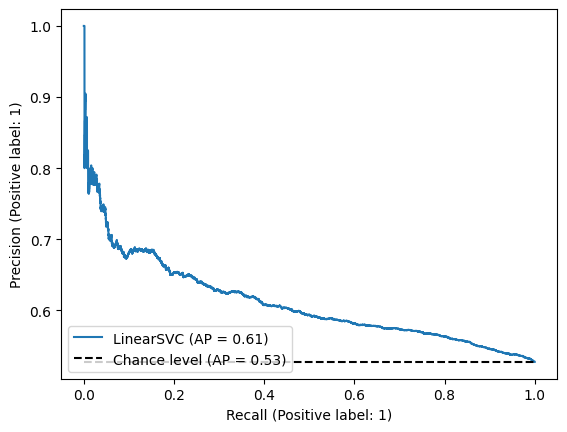

In [34]:
# XXX, yyy = X_test, y_test
XXX, yyy = X_val, y_val

preds = logreg_model.predict(XXX)
probas = logreg_model.predict_proba(XXX)

plot_prob_hist(probas)
compare_results(preds, yyy, XXX)
print(classification_report(yyy, preds))

sklearn.metrics.PrecisionRecallDisplay.from_estimator(
    logreg_model, XXX.copy(), yyy.copy(), name="LinearSVC", plot_chance_level=True
)

# Catboost

In [16]:
from catboost import CatBoostClassifier, Pool


cbt_model = CatBoostClassifier(
                iterations=20_000,                
                learning_rate=6e-3,
                depth=6,
                # boosting_type='Ordered',
                # bootstrap_type='Poisson' # GPU
                # class_weights={
                #     0: 0.53,
                #     1: 0.47
                # }
            )

eval_pool = Pool(X_val, label=y_val)

cbt_model.fit(
    X_train,
    y_train,
    eval_set=eval_pool,
    plot=True,
    silent=True,
    use_best_model=True
)

metrics = cbt_model.eval_metrics(
    data= eval_pool,
    metrics= ['AUC', 'Precision', 'Recall'],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,y_pred,y_true
0,0,1
1,0,1
2,1,1
3,1,1
4,1,1
...,...,...
9476,0,0
9477,0,1
9478,0,0
9479,1,0


              precision    recall  f1-score   support

           0       0.56      0.40      0.47      4478
           1       0.57      0.72      0.64      5003

    accuracy                           0.57      9481
   macro avg       0.57      0.56      0.55      9481
weighted avg       0.57      0.57      0.56      9481



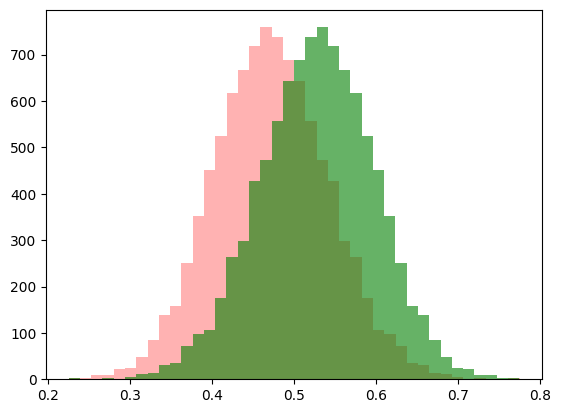

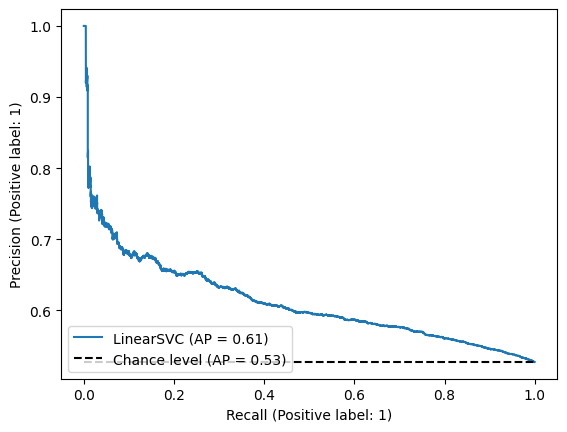

In [17]:
# XXX, yyy = X_test, y_test
XXX, yyy = X_val, y_val

preds = cbt_model.predict(XXX)
probas = cbt_model.predict_proba(XXX)

plot_prob_hist(probas)
compare_results(preds, yyy, XXX)
print(classification_report(yyy, preds))

sklearn.metrics.PrecisionRecallDisplay.from_estimator(
    cbt_model, XXX.copy(), yyy.copy(), name="LinearSVC", plot_chance_level=True
)

,preds,prob_dire,prob_radiant,X_test,y_test
2,1,0.361630,0.638370,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
7,1,0.331669,0.668331,"[0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0,...",1
12,1,0.345491,0.654509,"[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
15,0,0.633014,0.366986,"[0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1,...",1
22,1,0.398215,0.601785,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...
9468,0,0.618149,0.381851,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
9469,0,0.627513,0.372487,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0,...",0
9473,1,0.380791,0.619209,"[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
9475,1,0.345851,0.654149,"[0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


Lost 0.816 samples


,y_pred,y_true
0,1,1
1,1,1
2,1,1
3,0,1
4,1,1
...,...,...
1737,0,0
1738,0,0
1739,1,0
1740,1,0


              precision    recall  f1-score   support

           0       0.63      0.31      0.42       698
           1       0.66      0.88      0.75      1044

    accuracy                           0.65      1742
   macro avg       0.64      0.59      0.58      1742
weighted avg       0.64      0.65      0.62      1742



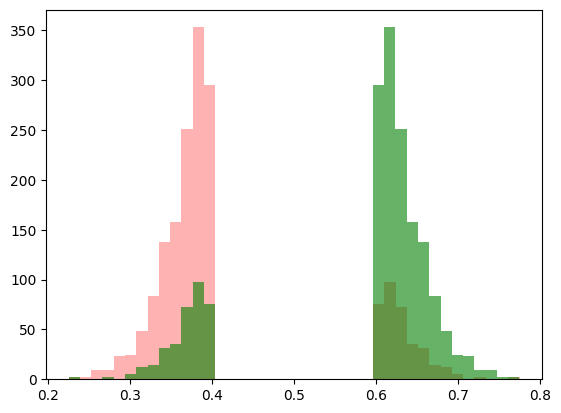

In [47]:
THRESHOLD = 0.6

# XXX, yyy = X_test, y_test
XXX, yyy = X_val, y_val

preds = cbt_model.predict(XXX)
probas = cbt_model.predict_proba(XXX)

df = pd.DataFrame()
df['preds'] = preds.tolist()
df['prob_dire'] = probas[:, 0].tolist()
df['prob_radiant'] = probas[:, 1].tolist()
df['X_test'] = XXX.tolist()
df['X_test'] = df['X_test'].apply(lambda x: np.array(x, dtype=np.int32))
df['y_test'] = yyy.tolist()
# df['y_test'] = df['y_test'].apply(lambda x: np.array(x, dtype=np.int32))

df_thr = df[(df['prob_dire'] > THRESHOLD) | (df['prob_radiant'] > THRESHOLD)]
display(df_thr)

probas_thr = np.concatenate(
    (
        df_thr['prob_dire'].to_numpy().reshape(-1, 1), 
        df_thr['prob_radiant'].to_numpy().reshape(-1, 1)
    ), axis=1)
preds_thr = df_thr['preds'].to_numpy()
X_test_thr = df_thr['X_test'].to_numpy()
y_test_thr = df_thr['y_test'].to_numpy()

print(f'Lost {1 - df_thr.shape[0] / df.shape[0]:.3f} samples')

plot_prob_hist(probas_thr)
compare_results(preds_thr, y_test_thr, X_test_thr)
print(classification_report(y_test_thr, preds_thr))


# sklearn.metrics.PrecisionRecallDisplay.from_estimator(
#     cbt_model, XXX.copy(), yyy.copy(), name="LinearSVC", plot_chance_level=True
# )

[1 0 0 ... 1 0 1]
[1 0 0 ... 1 0 1]


,y_pred,y_true
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
1977,1,1
1978,1,1
1979,1,1
1980,0,0


              precision    recall  f1-score   support

           0       0.90      0.92      0.91       946
           1       0.92      0.91      0.91      1036

    accuracy                           0.91      1982
   macro avg       0.91      0.91      0.91      1982
weighted avg       0.91      0.91      0.91      1982



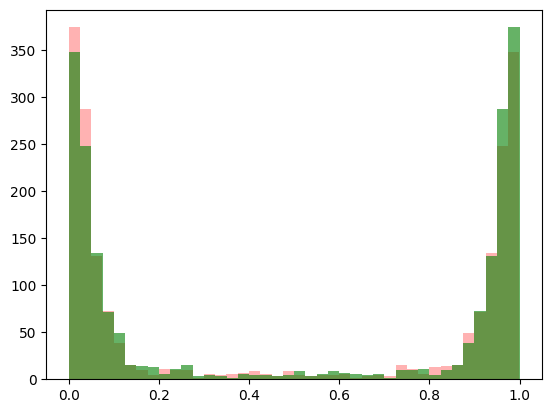

In [ ]:
preds = cbt_model.predict(X_val)
probas = cbt_model.predict_proba(X_val)

plot_prob_hist(probas)
compare_results(preds, y_val, X_val)
print(classification_report(y_val, preds))

In [15]:
model_name = 'HeroIds_0.91-F1.cbm'

cbt_model.save_model(
    fname='/Users/ankamenskiy/SmartDota/models/catboost/' + model_name,
    format="cbm"
)

In [33]:
import json
import sys
sys.path.append('../')

from lib.results_view import make_single_prediction

# print('LogReg:\n', make_single_prediction(logreg_model, 7599378829))
print('-'*50)
print('CatBoost:\n', make_single_prediction(cbt_model, 7599358486))

--------------------------------------------------
CatBoost:
 {'result': 'Radiant', 'dire': '0.28', 'radiant': '0.72'}
